In [209]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

### Building Micrograd

[Github](https://github.com/karpathy/micrograd)

Micrograd is an automatic gradient engine that implements back-propagation

Back-propagation efficiently evaluates the gradient of a loss function with respect to the weights of a neural network. This allows the weights to be "tuned" to minimize the loss function (accuracy of the network). This is at the core of training neural networks.

This micrograd implementation builds a mathematical expression graph and implements back-propagation for this expression graph. This library will not be dealing with Tensor inputs or outputs, but rather with scalar inputs and outputs. The underlying ideas and algorithms are the same as in Tensor-based libraries, but the implementation is much simpler. Therefore you can understand the core ideas of back-propagation and automatic differentiation without having to deal with the complexity of Tensors.

#### Understanding Derivatives

[Wikipedia](https://en.wikipedia.org/wiki/Derivative)

To understand back-propagation, you must first understand derivatives. The more intuitively you understand derivatives, the more intuitive back-propagation will be.

In [4]:
def f(x):
    return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

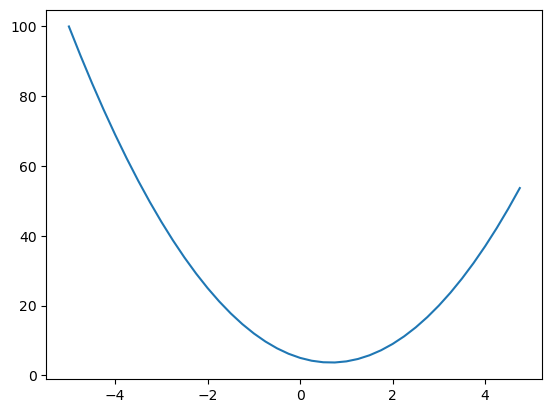

In [6]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.000001
x = 3.0
(f(x + h) - f(x)) / h

14.000003002223593

In [8]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x)) / h

-22.00000039920269

In [9]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [23]:
h = 0.00001

# inputs
a = 2.0
b = 3.0
c = 10.0

d = a*b + c

# da/dd, derivative of d with respect to a
da_dd = (a + h)*b + c
print(f'da/dd: {da_dd}')
print(f'slope: {(da_dd - d) / h}\n')

# db/dd, derivative of d with respect to b
db_dd = a*(b + h) + c
print(f'db/dd: {db_dd}')
print(f'slope: {(db_dd - d) / h}\n')

# dc/dd, derivative of d with respect to c
dc_dd = a*b + (c + h)
print(f'dc/dd: {dc_dd}')
print(f'slope: {(dc_dd - d) / h}')

da/dd: 16.000030000000002
slope: 3.0000000002416978

db/dd: 16.00002
slope: 1.9999999999242843

dc/dd: 16.00001
slope: 0.9999999999621422


## Expression Graph

The mathematical expression of a neural network will be quite large therefore it will be helpful to create abstractions to represent the different parts of the expression.

First we will implement a `Value` class to represent a scalar value.

In order to perform scalar operations on these values (add, multiply, subtract, etc.) you can use Python's overloading feature to override the `+`, `-`, `*`, `/` operators. This will allow you to write expressions like `a + b` and have it evaluate to a new `Value` object that represents the sum of `a` and `b`.

The connective tissue of this expression requires us to maintain pointers about what values produce what other values. This can be done by maintaining a set of child `Value` objects for each `Value` object. A `Value` object also needs to know the operations performed to create it

In [226]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        # the "effect" on the output, we initialize to zero to denote no "effect" on the output
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __neg__(self): # -self
        return self * -1
    
    def __add__(self, other): # self + other
        # Enables addition of non-Value values (assuming this is an integer or float)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        # This is using the principal realized below that the `+` operator is a
        # gradient routing function
        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)

    def __mul__(self, other): # self * other
        # Enables multiplication of non-Value values (assuming this is an integer or float)
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        # This is using the principal realized below that the `*` operator
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        # This enables code like, 2 * Value(2.0)
        return self * other

    def __pow__(self, other): # self**other
        assert isinstance(other, (int, float)), "only support for int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        # a / b = a * 1/b = a * b**-1
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        tan_h = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(tan_h, (self, ), 'tanh')
        # This can be found in the wikipedia link of "Hyperbolic Functions"
        def _backward():
            self.grad += (1 - tan_h**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        graph = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                graph.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(graph):
            node._backward()

In [123]:
# Code to visualize a `Value` node
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr=({'rankdir': 'LR'}))
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad,), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [124]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

### Back Propagation

The `backward` method of a `Value` object will recursively call the `backward` method of all child `Value` objects. This will propagate the gradient backwards through the expression graph. Practically speaking, we will be taking the derivative of `L` with respect to each of the nodes in the above visualization (including `L` itself). `L` is a neural network setting is the *loss function* and the nodes `a`, `b`, `c`, etc. are the weights of the neural network

In [68]:
def manual_back_prop():
    h = 0.0001

    # dL/dL = 1
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    print(f'dL/dL: {(L1 / L.data)}')
    
    # dL/da
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/da: {(L2 - L1) / h}')
    
    # dL/dd
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    d.data += h
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/dd: {(L2 - L1) / h}')
    
    # dL/df
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    f.data += h
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/df: {(L2 - L1) / h}')
    
    # dL/dc
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    c.data += h
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/dc: {(L2 - L1) / h}')
    
    # dL/de
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    e.data += h
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/de: {(L2 - L1) / h}')

    # dL/db
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/db: {(L2 - L1) / h}')
    
    # dL/da
    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    print(f'dL/da: {(L2 - L1) / h}')

manual_back_prop()

dL/dL: 1.0
dL/da: 6.000000000021544
dL/dd: -1.9999999999953388
dL/df: 3.9999999999995595
dL/dc: -1.9999999999953388
dL/de: -1.9999999999953388
dL/db: -4.000000000008441
dL/da: 6.000000000021544


The most important gradient to compute in order to develop a full understanding of back-prop and training neural networks is the gradient of `L` with respect to `c`. Since `c` effects the `d` node in some way, which effects `L` in some way, we can use this factor to help us computer `dL/dc`.

```
dL/dc = ??

dd/dc = 1.0
dd/de = 1.0
d = c + e

df/dx = (f(x + h) - f(x)) / h
dd/dc = ((c+h + e) - (c + e)) / h
      = (c + h + e - c - e) / h
      = h / h 
      = 1.0
```

To find `dL/dc` we need to use the chain rule. [Wikipedia: Chain Rule](https://en.wikipedia.org/wiki/Chain_rule). When we are using the chain rule with *dependent variables*, such as the case with `dL/dc`. The chain rule can be expressed as `dL/dc = dL/dd * dd/dc`

A worded explanation for intuition: "If a car travels `2` times faster as a bicycle and the bicycle is `4` times faster than a person walking, then the car is `2 * 4 = 8` times faster than a person walking."

With this understood we can now compute `dL/dc`:

```
dL/dc = dL/dd * dd/dc
      = -2.0 * 1.0
      = -2.0
dL/de = -2.0
```

Another inuition that can be derived from this, looking at the visualization below, the addition operation `+` can be thought of a "gradient routing" function, distrubuting the gradient of the parent node to it's children nodes.


Now calculating `dL/da` and `dL/db`, we can use our previous intuition to compute the gradients:

```
dL/da = ??

e = a * b

dL/de = -2.0

de/da = ??

df/dx = (f(x + h) - f(x)) / h

de/da = ((a + h) * b - (a * b)) / h
      = (a*b + b*h - a*b) / h
      = b*h / h
      = b = -3.0

de/db = ((b + h) * a - (b * a)) / h
      = (b*a + a*h - b*a) / h
      = a*h / h
      = a = 2.0

dL/da = dL/de * de/da
      = -2.0 * -3.0
      = 6.0

dL/db = dL/de * de/db
      = -2.0 * 2.0
      = -4.0
```

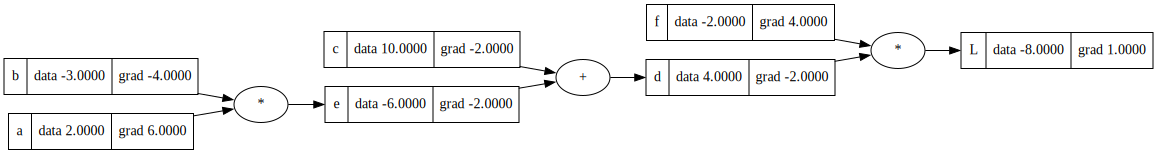

In [67]:
# This is a visualization of the forward pass
L.grad = 1.0 # dL/dL
a.grad = 6.0 # dL/da
d.grad = -2.0 # dL/dd
f.grad = 4.0 # dL/df
c.grad = -2.0 # dL/dc
e.grad = -2.0 # dL/de
b.grad = -4.0 # dL/db
a.grad = 6.0 # dL/da
draw_dot(L)

When developing neural networks, the weights you usually have control over are the leaf nodes. In our example this would be `a, b, c, f`. By modifying these values, you can influence the loss function `L` and therefore the accuracy of the neural network. Seeing this in practice:

In [69]:
print(f'L: {L.data}')
# By "effecting" our leaf nodes postively, we should see a positive "effect" of L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

# forward pass, simplified
e = a*b
d = e + c
L = d * f
print(f'Effected L: {L.data}')

L: -8.0
Effected L: -7.286496


### Back Propagation With a Neuron

Eventually we want to back propagate through a more complex neural network. 

*Biological Representation of Neuron*

![Bio Neuron](https://cs231n.github.io/assets/nn1/neuron.png)

*Mathematical Representation of Neuron*

![Math Neuron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

*Two-Layer (hidden) neural network*

![Neural Network](https://miro.medium.com/v2/resize:fit:720/format:webp/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png)

In the *mathematical representation of a neuron* image, we can see there is an activation function that is applied to the sum of the inputs. This activation function is applied to the sum of the inputs to introduce non-linearity into the network. This is important because without non-linearity, the network would be equivalent to a single linear function; which is not very powerful.

Activation functions are typically "squashing" functions for example, the *sigmoid function* or *tanh function*

Graphing `tanh(x)`, we can see the function squashes `y` values between `-1` and `1`.

[WolframLang tanh(x)](https://reference.wolfram.com/language/ref/Tanh.html)

[Wikipedia: Hyperbolic Functions](https://en.wikipedia.org/wiki/Hyperbolic_functions)

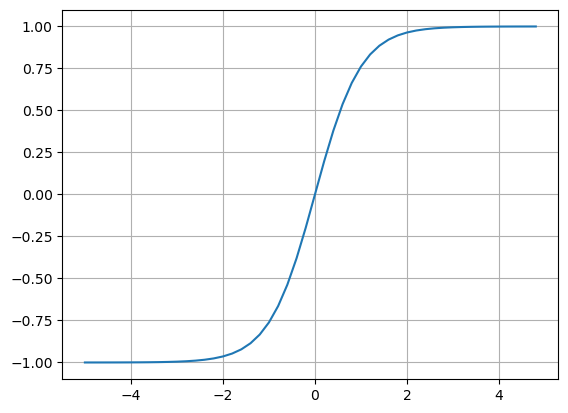

In [72]:
def tanh_graph():
    xs = np.arange(-5, 5, 0.2)
    ys = np.tanh(np.arange(-5, 5, 0.2))
    plt.plot(xs, ys)
    plt.grid()

tanh_graph()

Graphing `sigmoid(x)`, we can see the function squashes `y` values between `0` and `1`

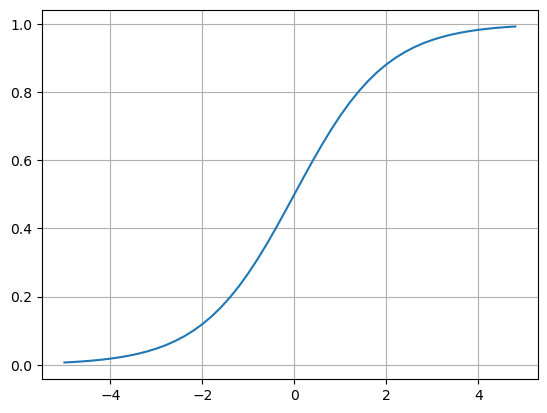

In [75]:
def graph_sigmoid():
    def sigmoid(x):
        return 1 / (1 + math.exp(-x))

    xs = np.arange(-5, 5, 0.2)
    ys = []
    for x in xs:
        y = sigmoid(x)
        ys.append(y)    

    plt.plot(xs, ys)
    plt.grid()

graph_sigmoid()

##### A Simple Neuron

In [200]:
# inputs (two-dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights (of neuron, synaptic strength of the inputs)
w1 = Value(-3.0, label='w1') 
w2 = Value(1.0, label='w2')
# bias, (number chosen for outputing "nice" numbers)
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
# cell body raw activation (without activation)
n = x1w1x2w2 + b; n.label = 'n'
# output
O = n.tanh(); O.label='o'

##### Back Propagation Through a Neuron

First we are interested in `dO/dO` which is `1.0`

Next we are interested in `dO/dn`,

```
O = tanh(n)
dO/dn = 1 - tanh(n)^2
      = 1 - o^2
      = 1 - O.data**2
      = 0.5
```

`dO/dx1w1x2x2`, `dO/dbv`, `dO/dx2w2`, `dO/dx1w1` can be computed in a similar fashion to the previous example using the fact that the `+` operation is a gradient routing function.

Finally to compute the last layer we must apply the knowledge of the `*` operator. We are interested in finding

In [96]:
O.data**2

0.5000000000000001

In [109]:
def manual_neuron_back_prop():
    # Caculated gradients
    O.grad = 1.0
    n.grad = O.data**2
    # `+` operator, route the parent gradient
    x1w1x2w2.grad = n.grad
    b.grad = n.grad
    # `+` operator, routing the parent gradient
    x2w2.grad = x1w1x2w2.grad
    x1w1.grad = x1w1x2w2.grad 
    # `*` operator
    x2.grad = w2.data * x2w2.grad
    w2.grad = x2.data * x2w2.grad
    # `*` operator
    x1.grad = w1.data * x1w1.grad
    w1.grad = x1.data * x1w1.grad

manual_neuron_back_prop()

In [152]:
def better_manual_neuron_back_prop():
    O.grad = 1.0
    O._backward()
    n._backward()
    x1w1x2w2._backward()
    x2w2._backward()
    x1w1._backward()

better_manual_neuron_back_prop()

##### Automating Back Propagation

In order to automate the process of back propagation, we need to compute the gradients of all nodes after it (looking from L to R), so that it's fully dependency graph is calculated. This ordering of graphs can be done with *topological sort*

In summary, Topological Sort of a directed graph (our neural network) is a linear ordering of its vertices (nodes) such that for every directed edge `(u,v)` from vertex `u` to vertex `v`, `u` comes before `v` in the ordering.

[Topological Sort](https://en.wikipedia.org/wiki/Topological_sorting)

![Topological Sort Image](https://assets.leetcode.com/users/images/63bd7ad6-403c-42f1-b8bb-2ea41e42af9a_1613794080.8115625.png)

In [161]:
def topo_sort(root):
    graph = []
    visited = set()

    def build_topo(node):
        if node not in visited:
            visited.add(node)
            for child in node._prev:
                build_topo(child)
            graph.append(node)
    
    build_topo(root)
    return graph

In [162]:
topo_sort(O)

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

Now we can put this all together to compute the gradients of all nodes in the network.

In [164]:
O.grad = 1.0

topo_graph = topo_sort(O)

for node in reversed(topo_graph):
    node._backward()

Placing the above logic into a `backward()` function on the `Value` class, we can now compute the gradients of all nodes in the network.

In [184]:
O.backward()

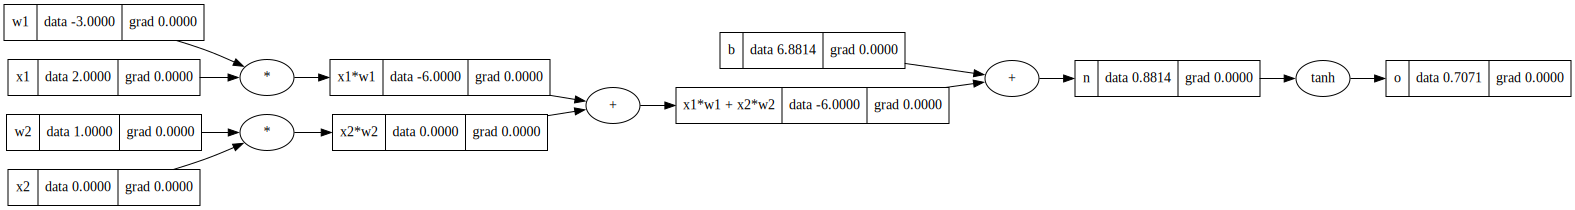

In [201]:
draw_dot(O)

The above result is the process of back propagation for a single neuron

#### Breaking down `tanh(x)`

As an exercise to further improve the operations our `Value` objects can perform, we will break down the `tanh(x)` operation into it's component parts. This highlights how backwards passes are constructed and flow. Also to show that the level of your operations is in the power of the implementor and not in the math itself. As long as the forward and backward passes are correct, it doesn't matter how much or how little you break down the operations.

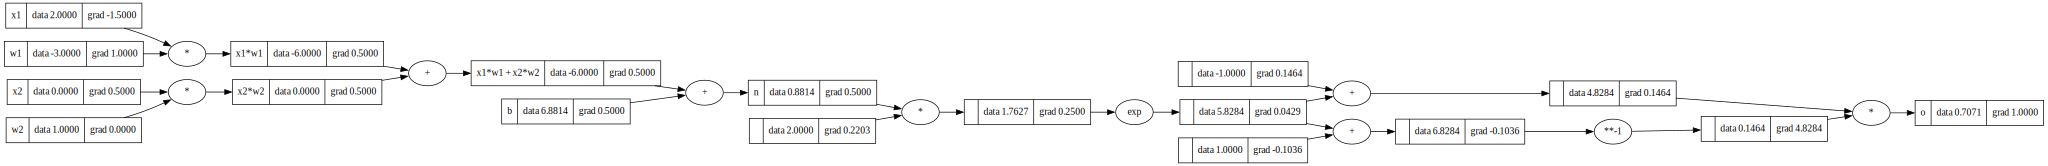

In [202]:
# inputs (two-dimensional neuron)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights (of neuron, synaptic strength of the inputs)
w1 = Value(-3.0, label='w1') 
w2 = Value(1.0, label='w2')
# bias, (number chosen for outputing "nice" numbers)
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
# cell body raw activation (without activation)
n = x1w1x2w2 + b; n.label = 'n'
# output
# O = n.tanh()
# ---- Rewriting n.tanh() ----
e = (2*n).exp()
O = (e - 1) / (e + 1)
# ----------------------------
O.label='o'
O.backward()
draw_dot(O)

The above visualization can be confirmed to be equivalent by the above visualization by checking on the gradient values of our inputs and weights. This ensures that back propagation functions the same as before when we used the `tanh(x)` operation directly

##### PyTorch Example

In production, you would a library such as [PyTorch](https://pytorch.org/) or [TensorFlow](https://www.tensorflow.org) to perform back propagation

We can see that the printed result is the same results as our own back propagation implementation.

The main difference here is that `micrograd` (our implementation) is a scalar valued engine, whereas `pytorch` is a tensor valued engine. Being tensor valued, it can parallelize the computation of the gradients of the entire network.

In [207]:
import torch

# inputs, `.double() = .to(torch.float64)`
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
# weights
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
# bias
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
O = torch.tanh(n)

print(f'O: {O.data.item()}')
O.backward()

print('----------------')
print(f'x1: {x1.grad.item()}')
print(f'w1: {w1.grad.item()}')
print(f'x2: {x2.grad.item()}')
print(f'w2: {w2.grad.item()}')

O: 0.7071066904050358
----------------
x1: -1.5000003851533106
w1: 1.0000002567688737
x2: 0.5000001283844369
w2: 0.0


#### Building a Neural Network Library

Now we are going to build a neural network library using our `Value` class. We will use this library to train a neural network. This will try to match the API of [PyTorch](https://pytorch.org/)

In [289]:
class Neuron:
    def __init__(self, number_of_inputs):
        self.w = [Value(random.uniform(-1,1)) for _ in range(number_of_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w.x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, number_of_inputs, number_of_outputs):
        self.neurons = [Neuron(number_of_inputs) for _ in range(number_of_outputs)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, number_of_inputs, number_of_outputs):
        sze = [number_of_inputs] + number_of_outputs
        self.layers = [Layer(sze[i], sze[i+1]) for i in range(len(number_of_outputs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [290]:
# Inputs
x = [2.0, 3.0]

In [291]:
# Forward a single neuron
n = Neuron(2)
n(x)

Value(data=-0.9933162958576225)

In [292]:
# A single layer of neurons
l = Layer(2, 3)
l(x)

[Value(data=-0.8990327983502613),
 Value(data=0.9820858000638293),
 Value(data=-0.8322808051080632)]

In [293]:
# Multi-layer perceptron
# This is replicating the above image titled "Two-layer (hidden) Neural Network"
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.06877249913693222)

In [295]:
# Weights and biases inside the entire neural network
len(mlp.parameters())

41

In [276]:
# M = mlp(x)
# M.backward()
# draw_dot(M)

In [296]:
# 4 possible inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]
# This can be used to build a simple binary classifier

In [297]:
# The predictions represent what the neural network "thinks" of the neural network
# By adjusting the weights we can influence the predictions to match our desired targets

[Value(data=-0.06877249913693222),
 Value(data=0.6750281270997652),
 Value(data=0.1862775225234826),
 Value(data=-0.021047744783292827)]

In [308]:
# The predictions represent what the neural network "thinks" of the neural network
# By adjusting the weights we can influence the predictions to match our desired targets
ypred = [mlp(x) for x in xs]

# To understand this "adjustment" process we have the neural network "emit" a value called the loss
# This loss tells us how well the neural network is doing, therefore we want to minimize this value
# to achieve the most accurate predictions. Can be thought of as the amount of missing information
# the neural network requires to accurately predict what you are asking of it

# Mean-squared Error Loss
# The lower these values are the closer we are to correctly predicting our desired outcomes
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.953166364100587)

In [370]:
# Say the above cell is the initial loss calculation, we can compute the loss after the backward pass, by 
# running the cell below, and the gradient descent optimization, by running the cell after that; We 
# should see the loss decrease by a small amount
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=1.4904958411969552e-18)

In [371]:
# Something "magical" happens we this function is ran
loss.backward()

In [372]:
# Gradient descent optimization (manually)
# Basically we are modifying the value of our parameters in our gradient descent scheme
# Gradient Descent: Thinking of the gradient as a vector pointing in the direction of increased loss
# We want to decrease the loss, therefore we multiply by the negative "adjustment"
for p in mlp.parameters():
    # This constant value we are multiplying by is known as the learning rate
    #
    # The value of this can be tricky to figure out because too high of a learning rate
    # can lead to "over confidence" and actually increase loss rather than decrease loss
    p.data += -0.1 * p.grad 

In [373]:
# This is considered succesful when our values are ~= [1.0, -1.0, -1.0, 1.0]
ypred

[Value(data=0.9999999991493178),
 Value(data=-0.9999999999998836),
 Value(data=-1.0),
 Value(data=0.9999999991243085)]

In [374]:
# draw_dot(loss)

##### Training Loop


In [385]:
# initialize neural network
mlp = MLP(3, [4, 4, 1])

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

actual_str = '['
for y in ys:
    actual_str += f'{y},'
actual_str += ']'

In [466]:
# Training Loop
epochs = 100
for k in range(epochs):
    # ==== Forward Pass =====
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    # ==== Zero Gradients ====
    # This is so the gradients are properly accumulated during backward pass
    # other wise gradients would influence other gradients improperly
    for p in mlp.parameters():
        p.grad = 0.0
    
    # ==== Gradient Descent =====
    # backward pass
    loss.backward()
    # update parameters
    for p in mlp.parameters():
        p.data += -0.05 * p.grad


    if k % 1 == 0:
        print(f'epoch: {k}, loss: {loss.data}')

epoch: 0, loss: 0.00020729262083552799
epoch: 1, loss: 0.00020721435104221727
epoch: 2, loss: 0.00020713613900705767
epoch: 3, loss: 0.00020705798466663045
epoch: 4, loss: 0.00020697988795762487
epoch: 5, loss: 0.00020690184881680168
epoch: 6, loss: 0.00020682386718102203
epoch: 7, loss: 0.00020674594298725313
epoch: 8, loss: 0.00020666807617252504
epoch: 9, loss: 0.0002065902666739843
epoch: 10, loss: 0.00020651251442886176
epoch: 11, loss: 0.00020643481937447433
epoch: 12, loss: 0.000206357181448234
epoch: 13, loss: 0.00020627960058764285
epoch: 14, loss: 0.00020620207673029744
epoch: 15, loss: 0.00020612460981387563
epoch: 16, loss: 0.00020604719977615607
epoch: 17, loss: 0.0002059698465550092
epoch: 18, loss: 0.00020589255008837784
epoch: 19, loss: 0.00020581531031431638
epoch: 20, loss: 0.00020573812717095214
epoch: 21, loss: 0.00020566100059651223
epoch: 22, loss: 0.00020558393052931098
epoch: 23, loss: 0.0002055069169077521
epoch: 24, loss: 0.0002054299596703236
epoch: 25, loss:

##### Summary

What is a Neural Network?

A neural network is a mathematical expression, simple in some cases, that take input as data (the weights and parmeters) with a mathematical forward pass, outputting a result known as the loss. 

This loss is then back propagated through the network, known as the backward pass, which accumulates gradients on the neurons of the network. Then gradient descent optimization is performed to "tune" the weights and parameters of the network to decrease the loss locally.

Scaling the number of neurons in a network, and the layers in a network, builds a dense, simulated network of neural tissue, enabling the network to be able to perform complex tasks.